In [3]:
import functions as func
import numpy as np
from sklearn.cluster import DBSCAN


file_path = '0000.wav'  # 目标文件
print('分析文件', file_path)

# 读取音频文件
data, sr = func.read_audio_file(file_path)
print('读取音频文件', data.shape, sr)
sample_size = sr // 5
sample_number = len(data) // sample_size

# 切分为0.2s的小段
sample_list = data[:sample_size * sample_number].reshape((sample_number, sample_size))
print('切分', sample_list.shape)

# 取特征值
mfcc_data = np.array([func.get_mfcc(sample, sr, 32) for sample in sample_list])
print('取到特征值', mfcc_data.shape)

# t-sne降维
tsne_data = func.get_tsne(mfcc_data, 2)  # 降至2维
print('t-sne降维处理', tsne_data.shape)

# 计算结果存储为csv文件
func.save_csv_file(tsne_data, 'temp.csv')
print('保存完成')

分析文件 0000.wav
读取音频文件 (9600000,) 16000
切分 (3000, 3200)
取到特征值 (3000, 32, 18)
t-sne降维处理 (3000, 2)
保存完成


In [1]:
import functions as func
import numpy as np
from sklearn.cluster import DBSCAN


# 加载csv文件内容
tsne_data = func.read_csv_file('temp.csv')
print(tsne_data.shape)

# 读取音频文件
file_path = '0000.wav'  # 目标文件
data, sr = func.read_audio_file(file_path)
print('读取音频文件', data.shape, sr)
sample_size = sr // 5
sample_number = len(data) // sample_size

# 可交互式绘图
import plotly.graph_objs as go
import plotly as py

f = go.FigureWidget([go.Scatter(x=tsne_data[:, 0], y=tsne_data[:, 1], mode='markers')])
f.layout.hovermode = 'closest'  # 鼠标吸附到最近点

def click_callback(trace, points, selector):
    import functions
    index = points.point_inds[0]
    if 2 <= index <= sample_number - 2:
        start = (index - 2) * sample_size
        end = (index + 3) * sample_size
        play = data[start: end]
        func.play_audio(play, sr)  # 播放这一段音频数据
        
scatter = f.data[0]
scatter.on_click(click_callback)
f

(3000, 2)
读取音频文件 (9600000,) 16000


FigureWidget({
    'data': [{'mode': 'markers',
              'type': 'scatter',
              'uid': 'c092ab7…

读取音频文件 (9600000,) 16000
DBSCAN聚类结果 {0, 1, 2, 3, -1}


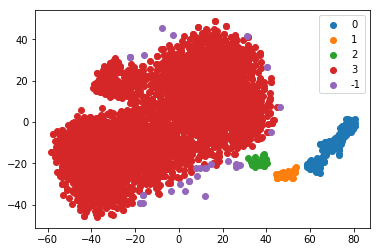

In [5]:
import functions as func
import numpy as np
from sklearn.cluster import DBSCAN


# 加载csv文件内容
tsne_data = func.read_csv_file('temp.csv')

# 读取音频文件
data, sr = func.read_audio_file(file_path)
print('读取音频文件', data.shape, sr)
sample_size = sr // 5
sample_number = len(data) // sample_size

# 聚类
estimator = DBSCAN(eps=4, min_samples=10)  # 参数
estimator.fit(tsne_data)  # 聚类
label_pred = estimator.labels_  # 获取聚类标签
print('DBSCAN聚类结果', set(label_pred))

# 绘图
func.show_2d_scatter(tsne_data, label_pred)

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  186  187  188  189  190  191  192  193  194  195
  196 

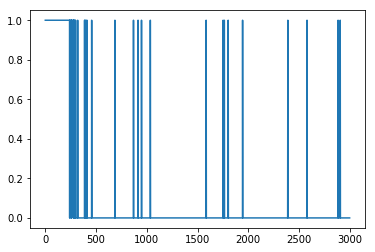

读取音频文件 (9600000,) 16000
298 960000
319 9600
411 86400
457 9600
686 9600
869 9600
914 9600
948 9600
1035 9600
1585 9600
1752 9600
1764 9600
1802 9600
1944 9600
2390 12800
2579 9600
2885 9600
2905 9600
完成


In [16]:
import functions as func
import numpy as np

# 在时间线上标时聚类出来的异常音频段
point_list = np.arange(len(tsne_data))[np.where(label_pred != 3)]
print(point_list)

time_point = np.zeros(shape=(len(tsne_data),), dtype=bool)
time_point[point_list] = True

func.show_1d_plot(time_point)


# 截取异常音频段 前0.2s+异常声音+后0.2s 如果两个异常之间间隔小于2s则合并为一段音频
# 读取音频文件
data, sr = func.read_audio_file(file_path)
print('读取音频文件', data.shape, sr)
sample_size = sr // 5
sample_number = len(data) // sample_size

index = 0
while index < len(point_list) - 1:
    point = point_list[index]
    next_point = point_list[index+1]

    start_point = (point - 1) * sample_size
    if(start_point < 0):
        start_point = 0

    while next_point - point <= 10 and index < len(point_list) - 2:  # 间隔时间小于2s
        index += 1
        point = point_list[index]
        next_point = point_list[index + 1]

    end_point = (point + 1 + 1) * sample_size

    audio_data = data[start_point:end_point]
    print(point, len(audio_data))
    func.save_audio_file(r'.\error_sound\{:04d}.wav'.format(point), audio_data, sr)
    index += 1

print('完成')